In [31]:
import pandas as pd
from fastai.collab import CollabDataBunch, collab_learner, load_learner, DatasetType, Path

In [32]:
user,item,title = 'userId','movieId','title'

In [33]:
cols = ['User ID','Movie ID','Rating','Timestamp']
ratings_df = pd.read_csv('ml-100k/u.data', delimiter='\t', 
                         header=None, names=[user,item,'rating','timestamp'])
ratings_df.sample(5)

,userId,movieId,rating,timestamp
72707,666,116,4,880313270
1457,13,121,5,882397503
98210,497,121,4,879310581
59509,281,342,1,881200789
53356,158,188,4,880134332


In [34]:
movies = pd.read_csv('ml-100k/u.item',  delimiter='|', encoding='latin-1', header=None, 
                     names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [35]:
rating_movie = ratings_df.merge(movies[[item, title]])
rating_movie = rating_movie[['userId', 'movieId', 'rating', 'title']]
rating_movie.head()

,userId,movieId,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


In [36]:
rows = []
user_id = 99999
movie_id = [755, 24, 96, 1013, 797, 751, 689, 685, 597, 2]
title = ["Jumanji", "Rumble in the Bronx", "Terminator 2: Judgment Day", "Anaconda", "Timecop", "Tomorrow Never Dies", "The Jackal", "Executive Decision", "Eraser", "GoldenEye"]
ratings = [4, 4, 4, 3, 4, 3, 3, 4, 3, 3]

for i in range(len(movie_id)):
  rows.append( dict( {'userId' : user_id, 'movieId' : movie_id[i], 'rating' : ratings[i], 'title': title[i]}))
user_data = pd.DataFrame(rows)
print(user_data)

userId  movieId  rating                       title
0   99999      755       4                     Jumanji
1   99999       24       4         Rumble in the Bronx
2   99999       96       4  Terminator 2: Judgment Day
3   99999     1013       3                    Anaconda
4   99999      797       4                     Timecop
5   99999      751       3         Tomorrow Never Dies
6   99999      689       3                  The Jackal
7   99999      685       4          Executive Decision
8   99999      597       3                      Eraser
9   99999        2       3                   GoldenEye


In [37]:
rating_movie = pd.concat([rating_movie, user_data], axis=0)
rating_movie.tail()

,userId,movieId,rating,title
5,99999,751,3,Tomorrow Never Dies
6,99999,689,3,The Jackal
7,99999,685,4,Executive Decision
8,99999,597,3,Eraser
9,99999,2,3,GoldenEye


In [38]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1)
data.show_batch()

userId,movieId,target
166,984,5.0
655,1499,3.0
776,179,4.0
504,1136,5.0
234,435,3.0


In [39]:
y_range = [0,5.5] # range of target variable
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


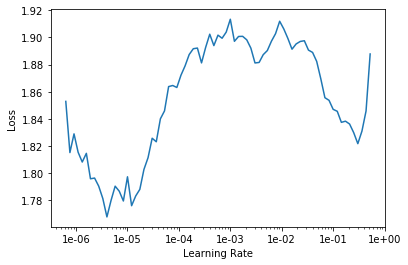

In [40]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [41]:
learn.fit_one_cycle(1, 0.01)

epoch,train_loss,valid_loss,time
0,0.869981,0.839561,00:05


In [42]:
(users, items), ratings = next(iter(data.valid_dl))
preds = learn.model(users, items)
print('Real\tPred\tDifference\tUser')
for p in list(zip(ratings, preds, users))[:16]:
  print('{}\t{:.1f}\t{:.1f}\t\t{}'.format(p[0],p[1],p[1]-p[0], p[2]))

Real	Pred	Difference	User
4.0	2.7	-1.3		234
5.0	4.2	-0.8		398
5.0	3.9	-1.1		97
2.0	2.7	0.7		155
5.0	3.7	-1.3		825
4.0	3.8	-0.2		504
5.0	5.0	-0.0		16
4.0	4.1	0.1		606
4.0	3.8	-0.2		22
3.0	2.6	-0.4		222
3.0	3.2	0.2		393
5.0	4.3	-0.7		398
2.0	2.9	0.9		399
2.0	2.9	0.9		363
3.0	4.0	1.0		123
3.0	3.2	0.2		846


In [43]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(945, 40)
  (i_weight): Embedding(1669, 40)
  (u_bias): Embedding(945, 1)
  (i_bias): Embedding(1669, 1)
)

In [44]:
learn.save("trained_100k_movie_model", return_path=True)

PosixPath('models/trained_100k_movie_model.pth')

In [24]:
# Logic from https://medium.com/@igorirailean/a-recommender-system-using-fastai-in-google-colab-110d363d422f
# https://github.com/IRailean/RecommenderSystem/blob/master/MovieTweetingRecommender.ipynb
rows = []
movies = list(rating_movie.drop_duplicates(subset='movieId', keep='first').movieId)
titles = list(rating_movie.drop_duplicates(subset='movieId', keep='first').title)
for i in range(len(movies)):
  rows.append( dict({'Title': titles[i], 'movieId' : movies[i], 'userId' : 99999}))
test_data = pd.DataFrame(rows)
test_data.head()

,Title,movieId,userId
0,Kolya (1996),242,99999
1,L.A. Confidential (1997),302,99999
2,Heavyweights (1994),377,99999
3,Legends of the Fall (1994),51,99999
4,Jackie Brown (1997),346,99999


In [45]:
# Load your model
data_collab_newuser = CollabDataBunch.from_df(rating_movie, test=test_data, seed=42, valid_pct=0.1)
learn_newuser = collab_learner(data_collab_newuser, n_factors=40, y_range=(0, 5), wd=1e-2)
learner = learn_newuser.load(Path("trained_100k_movie_model"))

In [49]:
# Logic from https://medium.com/@igorirailean/a-recommender-system-using-fastai-in-google-colab-110d363d422f
# https://github.com/IRailean/RecommenderSystem/blob/master/MovieTweetingRecommender.ipynb

preds, y = learner.get_preds(DatasetType.Test)
for idx, (score, title) in enumerate(sorted(zip(preds, titles), reverse=True)):
    if idx >= 10:
        break
    print("Score: ", round(float(score), 2), " for movie: ", title)

Score:  3.76  for movie:  Star Wars (1977)
Score:  3.68  for movie:  Shawshank Redemption, The (1994)
Score:  3.67  for movie:  Titanic (1997)
Score:  3.66  for movie:  Schindler's List (1993)
Score:  3.66  for movie:  Casablanca (1942)
Score:  3.62  for movie:  Godfather, The (1972)
Score:  3.6  for movie:  Manon of the Spring (Manon des sources) (1986)
Score:  3.58  for movie:  Indiana Jones and the Last Crusade (1989)
Score:  3.58  for movie:  Silence of the Lambs, The (1991)
Score:  3.58  for movie:  Contact (1997)
